# Wind field modelling for tropical cyclones

Based on the Python package CLIMADA, using the Holland (2008) model:
- Tutorial: https://climada-python.readthedocs.io/en/stable/tutorial/climada_hazard_TropCyclone.html
- Read the docs on TCTracks: https://github.com/CLIMADA-project/climada_python/blob/main/climada/hazard/tc_tracks.py
- Read the docs on TropCyclone: https://climada-python.readthedocs.io/en/stable/api/climada/climada.hazard.trop_cyclone.html

## For the historical tropical cyclone database IBTrACS

- Link: https://www.ncei.noaa.gov/products/international-best-track-archive

### Overview

This notebook follows the steps below: 
1. Preparations: loading packages and setting a standard for fonts/colour use
2. Generate centroids: create the points for which the modelling will take place
3. Load tracks: loading the TC tracks to be used
4. Model the hazard: modelling wind fields for all selected tracks, output to be saved

# 1. Preparations

### 1a. Load packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import time
import os
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
import climada
from climada.hazard import TCTracks
from climada.hazard import TropCyclone, Centroids
from climada.util.constants import SYSTEM_DIR

### 1b. Import functions out python file

In [5]:
import importlib
import TC_hazard_modelling

importlib.reload(TC_hazard_modelling)

# 2. Generate centroids
from TC_hazard_modelling import create_centroids_from_shapefiles
from TC_hazard_modelling import plot_all_grids_with_zoom

# 3. Load tracks
from TC_hazard_modelling import select_tracks
from TC_hazard_modelling import extract_selected_tracks


#4. Model the hazard
from TC_hazard_modelling import compute_windfields

### 1c. Create color palette and chose font

In [8]:
my_colors = {
    "510brown": "#c6bc8b",
    "510darkblue": "#00214d",
    "510lightblue": "#d4e6ff",
    "510red": "#dd281f",
    "510lightred": "#ff7876", 
    "510purple": "#958dbe"
}

plt.rcParams["font.family"] = "Arial"

# 2. Generate centroids: a grid of points from the country shapefiles

### 2a. Create a list of centroids per country

In [17]:
centroids_list, shapefiles_list = create_centroids_from_shapefiles(folder_path = "0-level-Leeward++",      # Path to folder of shapefile(s) 
                                                                   resolution_km = 2,                      # Desired resolution for point grid (km)
                                                                   buffer_km = 0)                          # Optional buffer around the borders of a shapefile (km)

Created centroids for 14 shapefiles.


### 2b. Optional: plot the created point grid

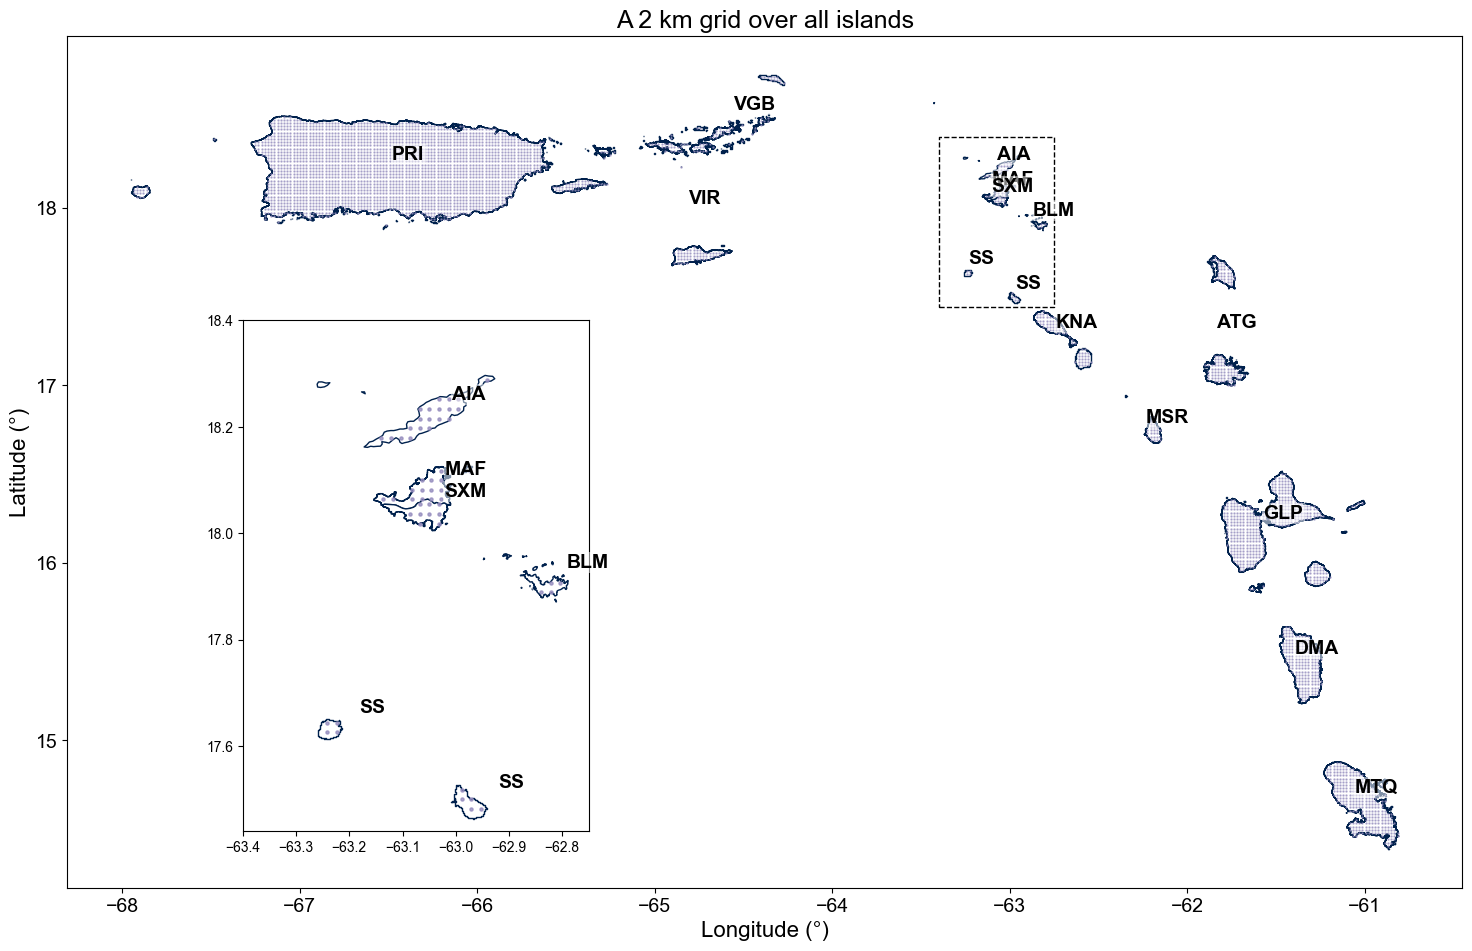

In [19]:
plot_all_grids_with_zoom(folder_path = "0-level-Leeward++",             # path to folder of shapefile(s)
                         shapefiles_list = shapefiles_list,             # Output of step 2a
                         centroids_list = centroids_list,                # Output of step 2a
                         my_colors = my_colors,                         # Optional: created in step 1
                         resolution_km = 2,                             # Same value as above
                         zoom_extent =(-63.4, -62.75, 17.44, 18.4))     # Zoomed view for readability

# Optional: Save plot as pdf/png/other
output_path = 'wind_figures/IBTrACS_windfields_pointgridLeewardIslands++.png'
plt.savefig(output_path, bbox_inches = 'tight')

plt.show();

# 3. Load IBTrACS data

### 3a. Use TCTracks to import tracks from IBTrACS

In [22]:
tracks = TCTracks.from_ibtracs_netcdf(provider = 'usa', basin="NA", year_range = (1940, 2024), interpolate_missing = True)
print("Number of tracks:", tracks.size)

2025-10-08 16:56:50,573 - climada.hazard.tc_tracks - WARNING - 280 storm events are discarded because no valid wind/pressure values have been found: 1940141N22289, 1940252N15313, 1940299N22288, 1941267N14300, 1942215N16275, ...
2025-10-08 16:56:50,606 - climada.hazard.tc_tracks - WARNING - 50 storm events are discarded because only one valid timestep has been found: 1940240N26295, 1940263N12279, 1940266N29311, 1940294N12281, 1942283N30289, ...
Number of tracks: 989


### 3b. Pre-select tracks passing the study area

In [24]:
tracks_LeewardIslands = select_tracks(tracks = tracks,                    # Output of step 3a
                                      lon_min = -69, lon_max = -58,       # -69 to -58 degrees West,
                                      lat_min = 12, lat_max = 21)         # 12 to 21 degrees North

print("Number of tracks:", tracks_LeewardIslands.size)

Number of tracks: 209


### 3c. Create a list of the storm IDs of the selected tracks and load tracks again

In [26]:
tr_ = extract_selected_tracks(tracks = tracks_LeewardIslands)

Number of tracks: 209


### 3d. Optional: plot selected tracks

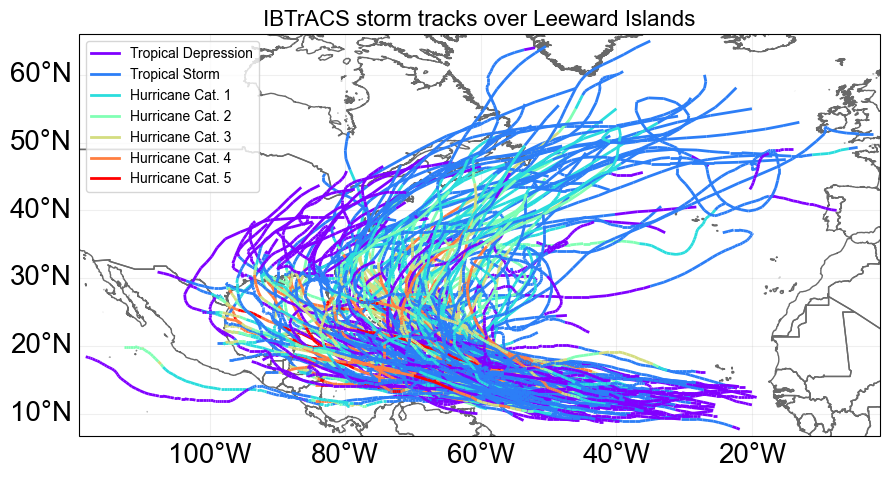

In [28]:
ax = tracks_LeewardIslands.plot()
ax.get_legend()._loc = 2 
ax.set_title("IBTrACS storm tracks over Leeward Islands", fontsize = 16)
ax.set_ylabel("Latitude", fontsize = 14)
ax.set_ylabel("Longiitude", fontsize = 14)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)


# Optional: Save plot as pdf/png/other
output_path = 'wind_figures/IBTrACS_windfields_tracks.pdf'
plt.savefig(output_path, bbox_inches = 'tight')   

plt.show(); 

# 4. Model the hazard

### 4a. Generate wind fields and save the maximum intensity for all storms per point in CSV files
_Runs in +/- 2 minutes_

In [31]:
start_time = time.time()

df = compute_windfields(tc_tracks_dict = tr_, 
                        centroids_list = centroids_list, 
                        shapefiles = shapefiles_list, 
                        output_csv_path = "wind_output/IBTrACS_windfields_all++.csv")

print(f'Running time: {(time.time() - start_time):.2f} seconds')

All results saved to wind_output/IBTrACS_windfields_all++.csv
Running time: 313.14 seconds


### 4b. Apply peak over threshold to only keep storms that lead to extreme values

In [50]:
df = pd.read_csv("wind_output/IBTrACS_windfields_all++.csv")

# Keep only storms that had *at least one* point ≥ 17.5 m/s
sids_to_keep = df[df['max_wind_speed_mps'] >= 17.5]['SID'].unique()
df_filtered = df[df['SID'].isin(sids_to_keep)]

df_filtered.to_csv("wind_output/IBTrACS_windfields_all++_POT.csv")

Original number of rows: 766,821
Filtered number of rows: 209,133
Rows removed: 557,688

Original number of storms (unique SIDs): 209
Filtered number of storms (unique SIDs): 57
Storms removed: 152

Maximum wind speed per storm (summary):
count    57.000000
mean     31.865493
std      13.628673
min      17.693809
25%      21.504860
50%      26.496962
75%      38.822161
max      69.986170
Name: storm_max_wind_mps, dtype: float64

Top 5 storms by maximum wind speed:
              SID  storm_max_wind_mps
49  2017260N12310           69.986170
47  2017242N16333           68.329116
18  1979238N12324           61.758519
25  1989254N13340           57.703569
28  1995241N11333           53.773895


In [12]:
df = pd.read_csv("wind_output/IBTrACS_windfields_all++.csv")

# Keep only points that have at least wind speed levels ≥ 17.5 m/s
df_filtered = df[df["max_wind_speed_mps"] >= 17.5] 

df_filtered.to_csv("wind_output/IBTrACS_windfields_all++_POT2.csv")

### 4c. Optional: check output

In [68]:
df = pd.read_csv("wind_output/IBTrACS_windfields_all++.csv")
df_filtered = pd.read_csv("wind_output/IBTrACS_windfields_all++_POT.csv")
print(f"Size of output: {df_filtered.size}")

print(f"\nOriginal number of storms (unique SIDs): {df['SID'].nunique():,}")
print(f"Filtered number of storms (unique SIDs): {df_filtered['SID'].nunique():,}")
print(f"Storms removed: {df['SID'].nunique() - df_filtered['SID'].nunique():,}")


# Compute the maximum wind speed per storm
storm_max = df_filtered.groupby('SID')['max_wind_speed_mps'].max().reset_index()
storm_max.rename(columns={'max_wind_speed_mps': 'storm_max_wind_mps'}, inplace=True)

print("\nMaximum wind speed per storm (summary):")
print(storm_max['storm_max_wind_mps'].describe())

print("\nTop 5 storms by maximum wind speed:")
print(storm_max.sort_values('storm_max_wind_mps', ascending=False).head())

Size of output: 1254798

Original number of storms (unique SIDs): 209
Filtered number of storms (unique SIDs): 57
Storms removed: 152

Maximum wind speed per storm (summary):
count    57.000000
mean     31.865493
std      13.628673
min      17.693809
25%      21.504860
50%      26.496962
75%      38.822161
max      69.986170
Name: storm_max_wind_mps, dtype: float64

Top 5 storms by maximum wind speed:
              SID  storm_max_wind_mps
49  2017260N12310           69.986170
47  2017242N16333           68.329116
18  1979238N12324           61.758519
25  1989254N13340           57.703569
28  1995241N11333           53.773895
